<h1>Generalized Autoregressive Data Simulation</h1>

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
%matplotlib inline


In [2]:
# Construct the model
class ARm(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, order):
        # Initialize the state space model
        super(ARm, self).__init__(endog, k_states=order, k_posdef = 1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = np.r_[1, np.zeros(self.k_states-1)]
        #self['design', 0, 0] = 1
        self['transition'] = np.eye(self.k_states, k = -1)
        self['selection', 0, 0] = 1
        
        self.positive_parameters = slice(self.k_states+1, self.k_states+2)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ARm, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:self.k_states]
        self['state_cov', 0, 0] = params[self.k_states]
        

    # Specify start parameters
    @property
    def start_params(self):
        ini = np.zeros(self.k_states+1)+0.15
        ini[self.k_states] = 1
        return ini  # 0s don't converge; 0.15 instead (need to be improved)
    
    def transform_params(self, unconstrained):
        """
        We constraint the last parameter to be positive,
        because it is variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        
        for i in range(self.k_states):
            constrained[i] = constrain_stationary_univariate(constrained[i:i+1])
            
        '''
        constrained[0] = constrain_stationary_univariate(constrained[0:1])
        constrained[1] = constrain_stationary_univariate(constrained[1:2])
        constrained[2] = constrain_stationary_univariate(constrained[2:3])
        '''
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        for i in range(self.k_states):
            unconstrained[i] = unconstrain_stationary_univariate(constrained[i:i+1])
        return unconstrained
        

<li>ARm<ol>
    <li>Phi: autoregression weight</li>
    <li>Sigma: variance of noice</li>
    </ol>
    
\begin{equation*}
{\phi}(L)y_{t} = \epsilon_t \\
(1-\sum_{1=1}^m a_iL^i)y_t = \epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
\end{equation*}
    
State Space Representation (Hamilton): 

\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & ... & 0
\end{vmatrix} \alpha_t \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & \phi_2 & ... & \phi_{m-1} & \phi_m \\
1 & 0 & ... & 0 & 0\\
... & ... & ... & ... & ...\\
0 & 0 & ... & 1 & 0 \\
\end{vmatrix} \alpha_t + \begin{vmatrix}
1 \\
0 \\
... \\
0
\end{vmatrix} \eta_t \\
\eta_t = \epsilon_{t+1} \sim N(0,\sigma^2)
\end{equation*}

In [7]:
# True model parameters (AR4 example)
nobs = int(1e3)
true_phim = np.r_[0.5, -0.2, 0.3]
true_sigma = 1**0.5

# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endogm = lfilter([1], np.r_[1, -true_phim], disturbances)

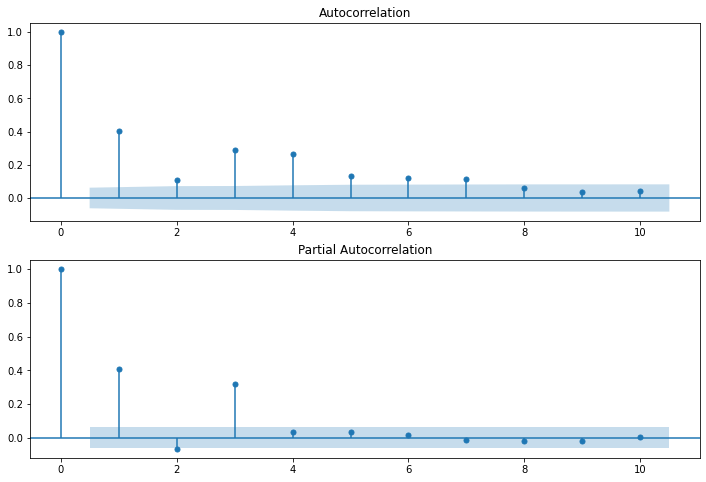

In [8]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(endogm.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(endogm.squeeze(), lags=10, ax=ax2)

In [8]:
mod = ARm(endogm,3)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                            ARm   Log Likelihood               -1390.022
Date:                Thu, 12 Jan 2023   AIC                           2788.044
Time:                        21:59:51   BIC                           2807.675
Sample:                             0   HQIC                          2795.505
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4534      0.029     15.844      0.000       0.397       0.510
param.1       -0.2044      0.034     -6.084      0.000      -0.270      -0.139
param.2        0.3207      0.032     10.073      0.0

In [88]:
res.aic

2788.92092777356

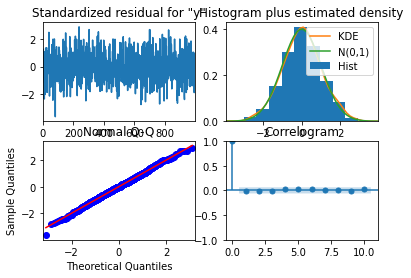

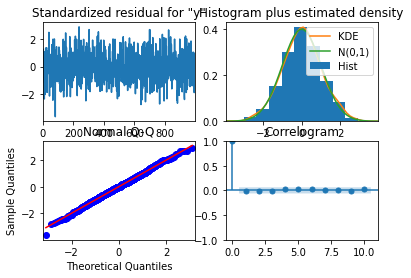

In [57]:
res.plot_diagnostics()

<h2>Jarque-Bera: [test_statistic, pvalue, skewness, kurtosis] </h2>
<h3>Goodness of fit </h3>

In [59]:
print(res.test_normality(method='jarquebera'))

[[ 0.23753265  0.88801528 -0.03460114  3.03019648]]


<h2>Goldfeld-Quandt type test: [test_statistic, pvalue] </h2>
<h3>Heteroskedasticity </h3>

In [61]:
print(res.test_heteroskedasticity(method='breakvar'))

[[1.05587354 0.62013254]]


<h2>Ljung-Box test: [test_statistic, pvalue] for each lag (overlap with plot_diagnostics)</h2> 
<h3>residuals from the ARIMA model have autocorrelation or not</h3>

In [62]:
print(res.test_serial_correlation(method='ljungbox'))

[[[0.12512417 0.18073023 0.43468683 0.77958307 2.0902451  3.05122921
   3.05166113 3.1722692  3.39787321 3.74236522]
  [0.72354202 0.91359756 0.93298738 0.94116409 0.83652229 0.80239011
   0.88018236 0.92308594 0.9464146  0.95822181]]]


/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<h2>AIC plot</h2>

In [92]:
orders = 7
AIC_df = pd.DataFrame()
for order in range(1,orders):
    mod = ARm(endogm,order)
    res = mod.fit()
    aic = res.aic
    temp = pd.DataFrame({'ar': [order],\
                            'aic': [aic]})
        
    AIC_df = AIC_df.append(temp)

<AxesSubplot:xlabel='ar', ylabel='aic'>

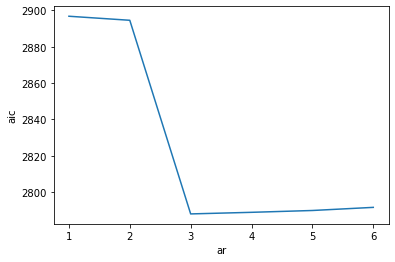

In [94]:
sns.lineplot(data = AIC_df, x = 'ar', y = 'aic')